In [1]:
%pip install --upgrade scikit-learn skrub


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd

df = pd.read_csv('titanic.csv')

In [4]:
df

,survived,pclass,name,sex,age,fare,sibsp,parch
0,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,1,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,1,0
2,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,1,0
4,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,0,0
...,...,...,...,...,...,...,...,...
709,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,29.1250,0,5
710,0,2,"Montvila, Rev. Juozas",male,27.0,13.0000,0,0
711,1,1,"Graham, Miss. Margaret Edith",female,19.0,30.0000,0,0
712,1,1,"Behr, Mr. Karl Howell",male,26.0,30.0000,0,0


In [6]:
from playtime.formula import feats, onehot, bag_of_words

formula = feats("age", "fare") + onehot("pclass", "sex") + bag_of_words("name") + feats("age", "fare") * onehot("pclass", "sex")
formula.pipeline.fit(df)

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('selectcols',
                                                 SelectCols(cols=['age',
                                                                  'fare']))])),
                               ('pipeline-2',
                                Pipeline(steps=[('selectcols',
                                                 SelectCols(cols=('pclass',
                                                                  'sex'))),
                                                ('onehotencoder',
                                                 OneHotEncoder())])),
                               ('pipeline-3',
                                Pipeline(steps=[('functiontransformer',
                                                 FunctionTransformer(func=<function column_pluck at 0x164fcd260>,
                                                                     kw_args={'column': 'name'})),
                                                ('countvectorizer',
                                                 CountVectorizer())])),
                               ('crosspolypipeline',
                                CrossPolyPipeline(union_estimator=FeatureUnion(transformer_list=[('pipeline-1',
                                                                                                  Pipeline(steps=[('selectcols',
                                                                                                                   SelectCols(cols=['age',
                                                                                                                                    'fare']))])),
                                                                                                 ('pipeline-2',
                                                                                                  Pipeline(steps=[('selectcols',
                                                                                                                   SelectCols(cols=('pclass',
                                                                                                                                    'sex'))),
                                                                                                                  ('onehotencoder',
                                                                                                                   OneHotEncoder())]))])))])

In [72]:
(formula.pipeline).fit(df)

FeatureUnion(transformer_list=[('pipeline-1',
                                Pipeline(steps=[('selectcols',
                                                 SelectCols(cols=['age',
                                                                  'fare']))])),
                               ('pipeline-2',
                                Pipeline(steps=[('selectcols',
                                                 SelectCols(cols=('pclass',
                                                                  'sex'))),
                                                ('onehotencoder',
                                                 OneHotEncoder())])),
                               ('pipeline-3',
                                Pipeline(steps=[('functiontransformer',
                                                 FunctionTransformer(func=<function column_pluck at 0x28acd36a0>,
                                                                     kw_args={'column': 'name'})),
                                                ('countvectorizer',
                                                 CountVectorizer())])),
                               ('crosspolypipeline',
                                CrossPolyPipeline(union_estimator=FeatureUnion(transformer_list=[('pipeline-1',
                                                                                                  Pipeline(steps=[('selectcols',
                                                                                                                   SelectCols(cols=['age',
                                                                                                                                    'fare']))])),
                                                                                                 ('pipeline-2',
                                                                                                  Pipeline(steps=[('selectcols',
                                                                                                                   SelectCols(cols=('pclass',
                                                                                                                                    'sex'))),
                                                                                                                  ('onehotencoder',
                                                                                                                   OneHotEncoder())]))])))])

In [56]:
import itertools as it
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csc_array, hstack, issparse

class CrossPolyPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, union_estimator):
        self.union_estimator = union_estimator

    def fit(self, X, y=None):
        X_tfm = self.union_estimator.fit_transform(X)
        self.split_marks_ = {}
        start = 0
        for name, tfm in self.union_estimator.transformer_list:
            width = tfm.transform(X[:2]).shape[1]
            self.split_marks_[name] = slice(start, width)
            start = width + start

        self.shape_out_ = start
        return self

    def transform(self, X):
        columns = []
        X_tfm = self.union_estimator.transform(X)
        if issparse(X_tfm):
            X_tfm = csc_array(X_tfm)
        for name1, name2 in it.combinations(self.split_marks_.keys(), 2):

            X1, X2 = X_tfm[:, self.split_marks_[name1]], X_tfm[:, self.split_marks_[name2]]
        for x in range(X2.shape[1]):
            columns.append(X1 * X2[:, [x]])
        if issparse(X_tfm):
            return hstack(columns, dtype=X_tfm.dtype).tocsc()
        return np.hstack(columns, dtype=X_tfm.dtype)

In [43]:
CrossPolyPipeline(formula.pipeline).fit(df)

CrossPolyPipeline(union_estimator=FeatureUnion(transformer_list=[('selectcols',
                                                                  SelectCols(cols=['age',
                                                                                   'fare'])),
                                                                 ('pipeline-1',
                                                                  Pipeline(steps=[('selectcols',
                                                                                   SelectCols(cols=('pclass',
                                                                                                    'sex'))),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder())])),
                                                                 ('pipeline-2',
                                                                  Pipeline(steps=[('functiontransformer',
                                                                                   FunctionTransformer(func=<function column_pluck at 0x1773d2f20>,
                                                                                                       kw_args={'column': 'name'})),
                                                                                  ('countvectorizer',
                                                                                   CountVectorizer())]))]))

In [41]:
formula.pipeline.fit_transform(df)

<714x1297 sparse matrix of type '<class 'numpy.float64'>'
	with 5772 stored elements in Compressed Sparse Row format>

<Axes: xlabel='timestamp'>

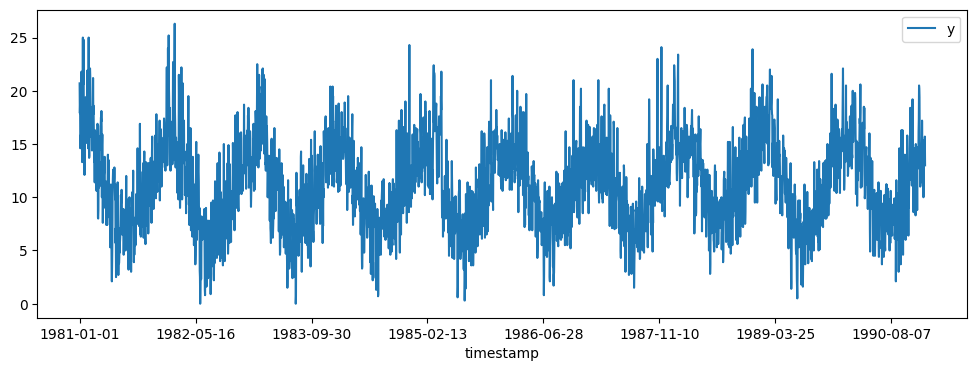

In [1]:
import polars as pl

pl.read_csv('datasets/me-temperatures.csv').to_pandas().plot("timestamp", "y", figsize=(12, 4))

In [17]:
import polars as pl 
pl.read_csv('datasets/me-temperatures.csv')['timestamp'].to_list()


['1981-01-01',
 '1981-01-02',
 '1981-01-03',
 '1981-01-04',
 '1981-01-05',
 '1981-01-06',
 '1981-01-07',
 '1981-01-08',
 '1981-01-09',
 '1981-01-10',
 '1981-01-11',
 '1981-01-12',
 '1981-01-13',
 '1981-01-14',
 '1981-01-15',
 '1981-01-16',
 '1981-01-17',
 '1981-01-18',
 '1981-01-19',
 '1981-01-20',
 '1981-01-21',
 '1981-01-22',
 '1981-01-23',
 '1981-01-24',
 '1981-01-25',
 '1981-01-26',
 '1981-01-27',
 '1981-01-28',
 '1981-01-29',
 '1981-01-30',
 '1981-01-31',
 '1981-02-01',
 '1981-02-02',
 '1981-02-03',
 '1981-02-04',
 '1981-02-05',
 '1981-02-06',
 '1981-02-07',
 '1981-02-08',
 '1981-02-09',
 '1981-02-10',
 '1981-02-11',
 '1981-02-12',
 '1981-02-13',
 '1981-02-14',
 '1981-02-15',
 '1981-02-16',
 '1981-02-17',
 '1981-02-18',
 '1981-02-19',
 '1981-02-20',
 '1981-02-21',
 '1981-02-22',
 '1981-02-23',
 '1981-02-24',
 '1981-02-25',
 '1981-02-26',
 '1981-02-27',
 '1981-02-28',
 '1981-03-01',
 '1981-03-02',
 '1981-03-03',
 '1981-03-04',
 '1981-03-05',
 '1981-03-06',
 '1981-03-07',
 '1981-03-

In [10]:
from playtime.formula import seasonal

formula = seasonal("timestamp")

In [11]:
formula.pipeline

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function datetime_feats at 0x73d13ec5a560>,
                                     kw_args={'column', 'timestamp'})),
                ('splinetransformer',
                 SplineTransformer(extrapolation='periodic', n_knots=12))])